In [1]:
import scipy.io as sio
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.stats import multivariate_normal

%matplotlib inline  

In [2]:
def drawRandomFromWeights(probs):
    u = np.random.uniform(0,np.sum(probs),1);
    select = 0;
    current = 0;
    for i in range(np.size(probs)):
        if (u > current) & (u < current + probs[i]):
            select = i;
        current = current + probs[i];
    
    return select

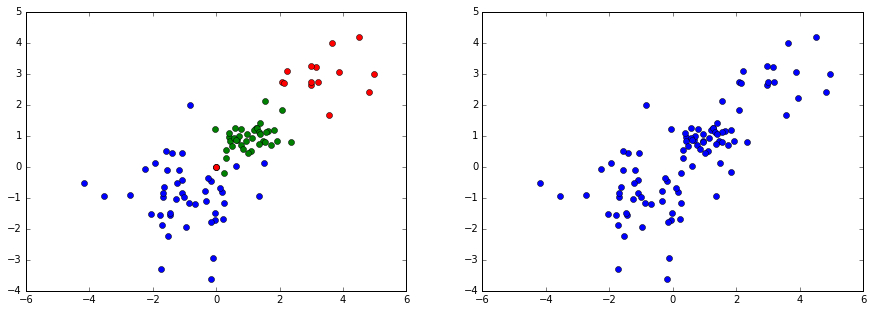

In [3]:
pi_true = np.array([0.35, 0.45, 0.2]);
mu_true = np.array([-1, 3, 1, 5, 3, 7]).reshape((3,2));
sigma_true = np.zeros((3,2,2));
sigma_true[0,:,:] = np.array([0.9, 0.1, 0.1, 0.9]).reshape(2,2);
sigma_true[1,:,:] = np.array([0.3, 0.7, 0.3, 0.7]).reshape(2,2);
sigma_true[2,:,:] = np.array([0.7, 0.3, 0.7, 0.3]).reshape(2,2);
col = ['r', 'g', 'b', 'k', 'c'];

N = 100;
v = np.zeros((np.size(pi_true), N, 2));
C = np.zeros((np.size(pi_true), 1)).astype(int);
obs = np.zeros((N,2));

for i in range(N):
    z = np.random.uniform(0,1,1)[0];
    idx = 0;
    sum2 = 0;
    
    for j in range(np.size(pi_true)):
        if (z>=sum2) & (z<=sum2+pi_true[j]):
            idx = j;
            break;
        else:
            sum2 = sum2 + pi_true[j];
    
    v_temp = np.random.multivariate_normal(mu_true[idx,:], sigma_true[idx,:,:],2);
    C[idx] = C[idx] + 1;
    v[idx, C[idx], 0] = v_temp[0][0];
    v[idx, C[idx], 1] = v_temp[1][0];
    obs[i,0] = v_temp[0][0];
    obs[i,1] = v_temp[1][0];

plt.figure(1, figsize = (15, 5));
plt.subplot(1, 2, 1)
for i in range(np.size(pi_true)):
    plt.plot(v[i,np.array(range(C[i])),0], v[i,np.array(range(C[i])),1], "o");
plt.subplot(1,2,2)
plt.plot(obs[:,0], obs[:,1], "o");

plt.show()

In [4]:
k = 3
itr = 100
showVisualization = [1, 2, 4, 8, 16, 32, 99]

itrGibbs = itr;
itrEM = itr;

In [5]:
mu = np.zeros((itrEM, k, 2))
sigma = np.zeros((itrEM, k, 2, 2))
pi = np.zeros((itrEM, k))
likelihood = np.zeros(itrEM-1)
assignment = np.zeros((N, k))

for i in range(k):
    mu[0, i] = obs[i]
    sigma[0, i] = np.eye(2)
    pi[0, i] = 1.0 / k

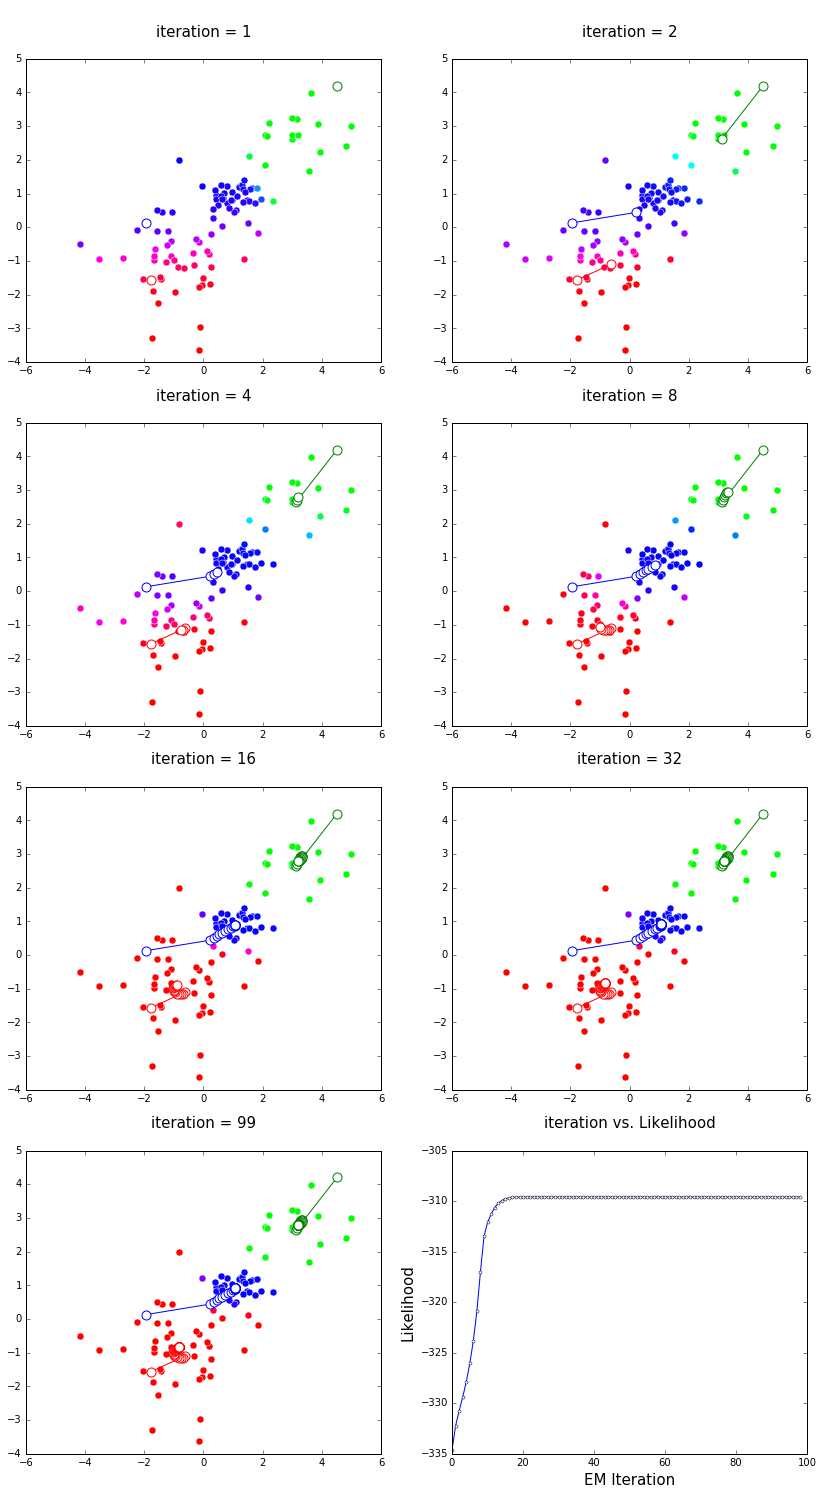

In [6]:
plt.figure(1, figsize=(14, 25), dpi=100)
plotN = 1
for i in range(1, itrEM):
    
    for j in range(N):
        for l in range(k):
            assignment[j, l] = pi[i-1, l] * multivariate_normal.pdf(obs[j, :], mu[i-1, l], sigma[i-1, l])
            
        assignment[j] /= np.sum(assignment[j])
    
    for j in range(k):
        normalize = 0
        mu[i, j] = np.zeros((1,2))
        
        for l in range(N):
            mu[i,j] += assignment[l, j] * obs[l]
            normalize +=  assignment[l, j]
        
        mu[i, j] /= normalize
        
    for j in range(k):
        normalize = 0
        sigma[i, j] = np.zeros((2,2))
        
        for l in range(N):
            sigma[i, j] += assignment[l, j] * np.multiply(np.transpose([obs[l] - mu[i, j]]), obs[l] - mu[i, j])
            normalize += assignment[l, j]
            
        sigma[i, j] /= normalize
   
    for j in range(k):
        for l in range(N):
            pi[i, j] += assignment[l, j]
            
        pi[i, j] /= N
        
    likelihood[i-1] = 0
    
    for j in range(N):        
        sumL = 0
        
        for l in range(k):
            sumL += pi[i, l] * multivariate_normal.pdf(obs[j], mu[i, l], sigma[i, l])
        
        likelihood[i - 1] += np.log(sumL)
        
    if i in showVisualization:
        plt.subplot(4, 2, plotN)
        plt.title(' \niteration = %s\n'%(i), fontsize=15)
        plotN += 1
        
        for j in range(N):
            assignment[j] /= np.max(assignment[j])
            plt.plot(obs[j, 0], obs[j, 1], 'o', markersize = 7, 
                     markerfacecolor = (assignment[j, 0], assignment[j, 1], assignment[j, 2]), markeredgecolor = 'w')
        
        for j in range(k):
            points = np.zeros((i, 2))
            
            for l in range(i):
                points[l] = mu[l, j]
                
            plt.plot(points[:, 0], points[:, 1], color = col[j])
            plt.plot(points[:, 0], points[:, 1], 'wo', markeredgecolor = col[j], markersize = 9, markeredgewidth = 1)
            
plt.subplot(4, 2, 8)
plt.title('iteration vs. Likelihood\n', fontsize=15)
plt.xlabel('EM Iteration', fontsize = 15)
plt.ylabel('Likelihood', fontsize = 15)
plt.plot(likelihood[:])
plt.plot(likelihood[:], 'wo', markersize = 3)


plt.show()

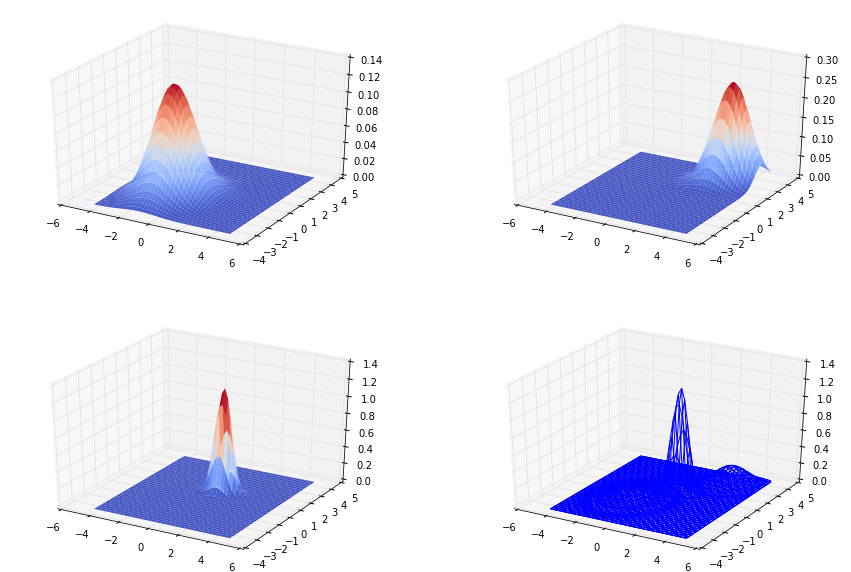

In [7]:
fig = plt.figure(1, figsize=(15,10))
x = np.linspace(np.min(obs[:,0]), np.max(obs[:,0]), (np.max(obs[:,0])-np.min(obs[:,0])/0.1))
y = np.linspace(np.min(obs[:,1]), np.max(obs[:,1]), (np.max(obs[:,1])-np.min(obs[:,1])/0.1))
[X, Y] = np.meshgrid(x,y)
temp = np.column_stack([X.reshape(np.size(X),1), Y.reshape(np.size(Y),1)])

for j in range(k):
    Z = multivariate_normal.pdf(temp, mu[itrGibbs-1, j], sigma[itrGibbs-1, j])
    #Z = np.reshape(Z, np.size(np.reshape(np.size(X),1)))
    #Z = Z.reshape(np.size(X.reshape(np.size(X),1)))
    Z = Z.reshape(np.size(y), np.size(x))
    ax = fig.add_subplot(2, 2, j+1,projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=True)

ax = fig.add_subplot(2, 2, 4,projection='3d')
for j in range(k):
    Z = multivariate_normal.pdf(temp, mu[itrGibbs-1, j], sigma[itrGibbs-1, j])
    Z = Z.reshape(np.size(y), np.size(x))
#     surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=True, alpha = 0.7)
    surf = ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)
plt.show()

C:\Users\Do-Hyeong\Anaconda2\lib\site-packages\ipykernel\__main__.py:71: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


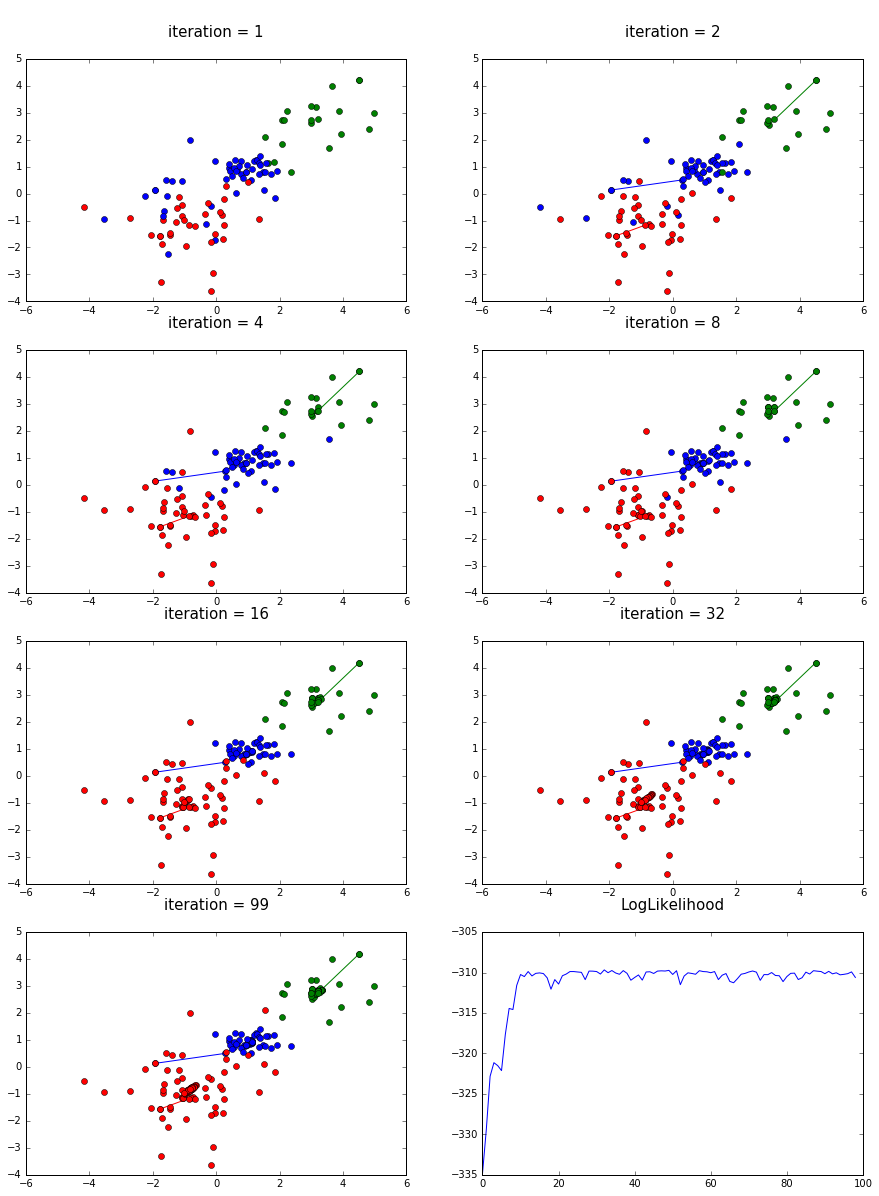

In [8]:
plt.figure(1, figsize = (15,20))
#mu = np.zeros((itrGibbs, k), dtype=np.object)
#sigma = np.zeros((itrGibbs, k), dtype=np.object)
mu = np.zeros((itrGibbs, k, 2))
sigma = np.zeros((itrGibbs, k, 2, 2))
pi = np.zeros((itrGibbs, k))
likelihood2 = np.zeros((itrGibbs-1, 1))
z = np.zeros((N,1)).astype(int)
figCount = 1;

for i in range(k):
    mu[0,i] = obs[i,:]
    sigma[0,i] = np.eye(2)
    pi[0,i] = 1/float(k)

for i in range(1,itrGibbs):
    for j in range(N):
        normalize = 0;
        probs_z = np.zeros((k,1))
        for l in range(k):
            probs_z[l] = pi[i-1,l] * multivariate_normal.pdf(obs[j,:], mu[i-1,l], sigma[i-1,l])
            normalize = normalize + probs_z[l]
        for l in range(k):
            probs_z[l] = probs_z[l] / normalize
        z[j] = drawRandomFromWeights(probs_z)
    
    count = np.zeros((k,1))
    for j in range(k):
        mu[i,j] = np.zeros((1,2));
    for j in range(N):
        mu[i,z[j]] = mu[i,z[j]] + obs[j,:];
        count[z[j]] = count[z[j]] + 1;
    for l in range(k):
        mu[i,l] = mu[i,l] / count[l];
    
    for j in range(k):
        sigma[i,j] = np.zeros((2,2))
    for j in range(N):
        sigma[i,z[j]] = sigma[i,z[j]] + np.dot(np.transpose((obs[j,:]-mu[i,z[j]])), (obs[j,:]-mu[i,z[j]]))
    for l in range(k):
        sigma[i,l] = sigma[i,l] / count[l];
    for l in range(k):
        pi[i,l] = count[l] / np.sum(count);
    
    likelihood2[i-1] = 0;
    for j in range(N):
        sum2 = 0;
        for l in range(k):
            sum2 = sum2 + pi[i,l] * multivariate_normal.pdf(obs[j,:], mu[i,l], sigma[i,l])
        likelihood2[i-1] = likelihood2[i-1] + np.log(sum2);
    
    flag = 0;
    for j in range(np.size(showVisualization)):
        if showVisualization[j] == i:
            flag = 1
            break;
    
    if flag == 0:
        continue;
    
    plt.subplot(4,2,figCount)
    plt.title(' \niteration = %s\n'%(i), fontsize=15)
    
    for j in range(k):
        points = np.zeros((i,2));
        for l in range(i):
            points[l,:] = mu[l,j]
        plt.plot(points[:,0], points[:,1], color=col[j])
        plt.plot(points[:,0], points[:,1], "o", color = col[j])
    for j in range(N):
        plt.plot(obs[j,0],obs[j,1], "o", color = col[z[j]])
    figCount = figCount + 1;
    
plt.subplot(4,2,8)
plt.title('LogLikelihood\n', fontsize = 15)

plt.plot(np.array(range(itrGibbs-1)), likelihood2[:]);

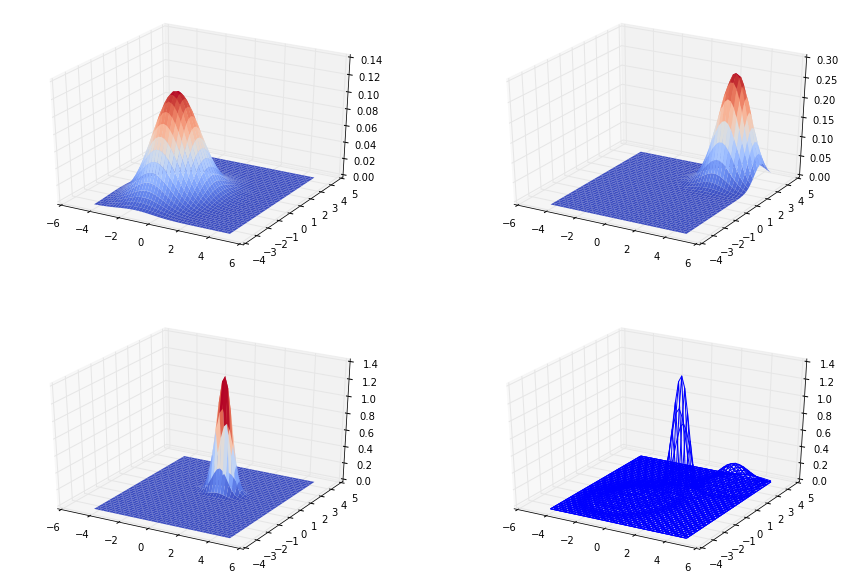

In [9]:
fig = plt.figure(1, figsize=(15,10))
x = np.linspace(np.min(obs[:,0]), np.max(obs[:,0]), (np.max(obs[:,0])-np.min(obs[:,0])/0.1))
y = np.linspace(np.min(obs[:,1]), np.max(obs[:,1]), (np.max(obs[:,1])-np.min(obs[:,1])/0.1))
[X, Y] = np.meshgrid(x,y)
temp = np.column_stack([X.reshape(np.size(X),1), Y.reshape(np.size(Y),1)])

for j in range(k):
    Z = multivariate_normal.pdf(temp, mu[itrGibbs-1, j], sigma[itrGibbs-1, j])
    #Z = np.reshape(Z, np.size(np.reshape(np.size(X),1)))
    #Z = Z.reshape(np.size(X.reshape(np.size(X),1)))
    Z = Z.reshape(np.size(y), np.size(x))
    ax = fig.add_subplot(2, 2, j+1,projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=True)

ax = fig.add_subplot(2, 2, 4,projection='3d')
for j in range(k):
    Z = multivariate_normal.pdf(temp, mu[itrGibbs-1, j], sigma[itrGibbs-1, j])
    Z = Z.reshape(np.size(y), np.size(x))
#     surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=True, alpha = 0.7)
    surf = ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)
plt.show()

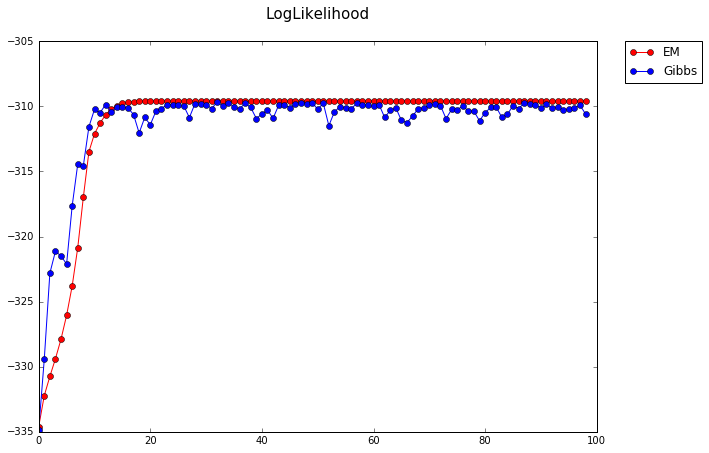

In [10]:
plt.figure(1, figsize = (10,7))
plt.title('LogLikelihood\n', fontsize = 15)

plt.plot(np.array(range(itrEM-1)), likelihood[:],'-o', color='r', label="EM");
plt.plot(np.array(range(itrGibbs-1)), likelihood2[:],'-o', color='b', label="Gibbs");

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show();